In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utils.make_pairs import make_pairs

## Prepare Data For Siamese Network

Load Data and Labels

In [53]:
train_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_train'
val_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_val'

file_paths_train = tf.data.Dataset.list_files(train_data_dir + '/*.jpg')
file_paths_val = tf.data.Dataset.list_files(val_data_dir + '/*.jpg')

# Define the function to extract the label from the file name
# works for my specific directory path...
def extract_label(file_path):
    label = tf.strings.split(file_path, '_')
    label = tf.strings.split(label, '\\')
    return int(label[2][1])

def read_and_decode(file_path):
    label = extract_label(file_path)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

print("[INFO] loading data...")

dataset_train = [read_and_decode(file) for file in file_paths_train]
dataset_val = [read_and_decode(file) for file in file_paths_val]

[INFO] loading data...


Visualize Training Data

IMAGE SHAPE:  (128, 64, 3)


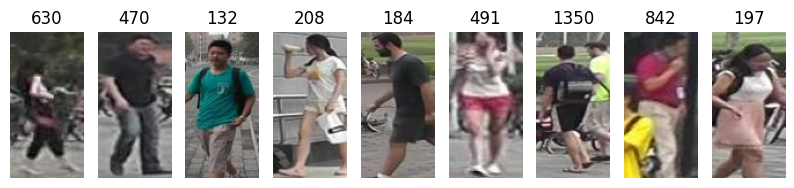

In [ ]:
plt.figure(figsize=(10, 10))
subplot_pos = 1

for image, label in dataset_train[:9]:
  ax = plt.subplot(1, 9, subplot_pos)
  subplot_pos += 1
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")

print("IMAGE SHAPE: ", image.shape)

In [ ]:
labels = [label for image, label in dataset_train]
unique_labels = np.unique(np.array(labels))

idxs = [np.where(labels == unique_label)[0] for unique_label in unique_labels]

for unique_label in unique_labels:
    idxs = np.where(labels == unique_label)[0]
    print(f"{unique_label} => {len(idxs)} : {idxs}")

2 => 46 : [   74   688   888  1293  1942  2082  2291  2383  2414  2446  2582  2671
  3271  3314  3352  3612  3621  3847  3974  4299  4958  5230  5885  6086
  6560  6577  7450  7622  7665  8075  8162  8217  8559  8763  9409  9413
  9595  9720 10234 10338 10602 11371 11874 12170 12273 12736]
7 => 7 : [ 815 1870 2715 3979 4429 6737 8091]
10 => 11 : [ 2325  3562  4236  4830  5798  6392  9923 10016 10549 10822 11486]
11 => 15 : [   96   507  1637  1839  2085  2398  3695  3909  6128  6916  8373  8471
 11260 11848 11884]
12 => 6 : [ 547 1060 1334 2425 5925 6938]
20 => 6 : [ 1220  2689  4430  6188  7426 10633]
22 => 59 : [  200   254   518   535   663   715   788   809   992  1483  1793  1960
  2323  2449  2590  3201  3242  3327  3373  3540  3582  3791  4495  4620
  4736  5835  5911  6289  6369  6437  6864  7018  7237  7411  7670  7841
  7860  7868  8256  8307  8558  8583  8592  8593  8799  8880  9436  9859
 10252 10443 10452 10706 11115 11746 11777 11927 12195 12237 12584]
23 => 20 : [  180  

Make Pairs

In [ ]:
train_pair_x, train_pair_y = make_pairs(dataset_train)
val_pair_x, val_pair_y = make_pairs(dataset_val)

c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


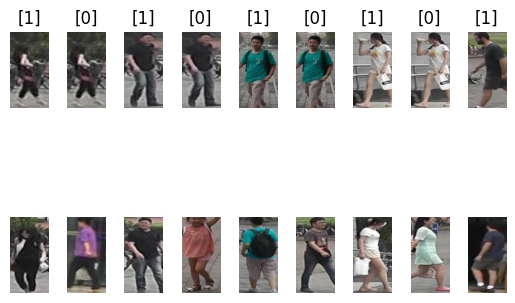

In [ ]:
fig, axes = plt.subplots(2, 9)
plt.subplots_adjust(wspace=0.5, hspace=0)
j = 0

for img_1, img_2 in train_pair_x[:9]:
  axes[0, j].imshow(img_1)
  axes[1, j].imshow(img_2)
  axes[0, j].set_title(train_pair_y[j])
  axes[0, j].set_axis_off()
  axes[1, j].set_axis_off()
  j += 1

## Creating Siamese Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from utils.euclidean_distance import euclidean_distance

Choose a pretrained model

In [ ]:
# the image size for all the images in The Market Dataset is 128x64
IMG_SHAPE = (128, 64, 3)

# Create the base model from the pre-trained model MobileNet V2
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
feature_extractor.trainable = False

In [ ]:
feature_extractor.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 32, 32)   864         ['input_10[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 32, 32)   0           ['bn_Conv1[0][

Configure Siamese Network

In [ ]:
print("[INFO] building model...")
img_1 = Input(shape=IMG_SHAPE)
img_2 = Input(shape=IMG_SHAPE)

features_1 = feature_extractor(img_1)
features_2 = feature_extractor(img_2)
distance = Lambda(euclidean_distance)([features_1, features_2])
pooling = GlobalAveragePooling2D(distance)
outputs = Dense(1, activation="sigmoid")(pooling)
model = Model(inputs=[img_1, img_2], outputs=outputs)   

[INFO] building model...


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_14 (InputLayer)          [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 4, 2, 1280)  2257984     ['input_13[0][0]',               
 al)                                                              'input_14[0][0]']         

## Training Siamese Network

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

tensoboard_dir = r"C:\Users\jands\Project_Shaman\Siamese Network\tensorboard_logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensoboard_dir, histogram_freq=1)

# compile the model
print("[INFO] compiling model...")
base_learning_rate = 0.0001
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
	metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit(
	[train_pair_x[:, 0], train_pair_x[:, 1]], train_pair_y[:],
	validation_data=([val_pair_x[:, 0], val_pair_x[:, 1]], val_pair_y[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=[tensorboard_callback])

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (371057639.py, line 4)